<h1 style="font-size: 1.6rem; font-weight: bold">ITO 5047: Fundamentals of Artificial Intelligence</h1>
<h1 style="font-size: 1.6rem; font-weight: bold">Machine Learning Methods: Naïve Bayes (Gaussian Exercise)</h1>
<p style="margin-top: 5px; margin-bottom: 5px;">Monash University Australia</p>
<p style="margin-top: 5px; margin-bottom: 5px;">Jupyter Notebook by: Tristan Sim Yook Min</p>
References: Information Source from Monash Faculty of Information Technology

---


### **Python Exercise: Naive Bayes (Gaussian - Machine Predictive Maintenance Classification)**

Gaussian Naive Bayes is ideal for predictive maintenance using continuous sensor readings like temperature, vibration levels, pressure, or RPM. For example, it learns that failing machines typically have vibration levels around 85±10 Hz and temperature around 95±5°C, while healthy machines show 45±8 Hz and 70±3°C, then classifies whether a machine needs maintenance based on where its current sensor readings fall within these distributions.

The Example Below shows the Machine Predictive Maintenance Classification Dataset from Kaggle.

#### **1) Dataset Information**

##### **Machine Predictive Maintenance Classification Dataset**

A synthetic dataset reflecting real industrial predictive maintenance scenarios with **10,000 data points** and **14 features**.

| Feature | Description | Details |
|---------|-------------|---------|
| **UID** | Unique identifier | Range: 1 to 10,000 |
| **Product ID** | Product quality variant + serial number | L (Low - 50%), M (Medium - 30%), H (High - 20%) |
| **Air Temperature [K]** | Ambient temperature | Random walk, σ = 2K, centered at 300K |
| **Process Temperature [K]** | Operating temperature | Air temp + 10K, σ = 1K |
| **Rotational Speed [rpm]** | Shaft rotation speed | Calculated from 2860W power with noise |
| **Torque [Nm]** | Applied torque | Normal distribution: μ = 40Nm, σ = 10Nm (no negatives) |
| **Tool Wear [min]** | Cumulative tool usage | H/M/L variants add 5/3/2 minutes respectively |

##### **Targets**

| Target | Description |
|--------|-------------|
| **Target** | Binary: Failure or Not |
| **Failure Type** | Categorical: Type of failure |

**Critical Warning**: Both are targets so **do not use one as a feature** to avoid data leakage!

**Data leakage** occurs when information from outside the training dataset (or from the target itself) is used to create the model, artificially inflating performance. The model appears highly accurate during training/testing but fails in real-world deployment because the leaked information isn't available when making actual predictions.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn.preprocessing     # Preparing & Transforming Data before Training
import sklearn.model_selection   # Splitting & Validating Dataset
import sklearn.naive_bayes       # Naive Bayes Classification Algorithm
import sklearn.metrics           # Evaluating Model Metrics

# Load the Dataset Downloaded from Kaggle: Machine Predictive Maintenance Classification
# Link: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
file_path = os.path.join("resources","datasets","predictive_maintenance.csv")

# Create Data Frame to Store the CSV Data
pred_maint_df = pd.read_csv(file_path)

# Print the Dataset Information
print(f"Dataset Shape: {pred_maint_df.shape}")
print(f"Columns: {pred_maint_df.columns.to_list()}")
print(f"\nFirst 5 Rows of Data:")
display(pred_maint_df.head())

# Data Set Information
total_num_of_data = len(pred_maint_df)
print(f"\nTotal Number of Records: {total_num_of_data}")

Dataset Shape: (10000, 10)
Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']

First 5 Rows of Data:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure



Total Number of Records: 10000


#### **2) Explore the Dataset**

Target Distribution (Binary Failure):


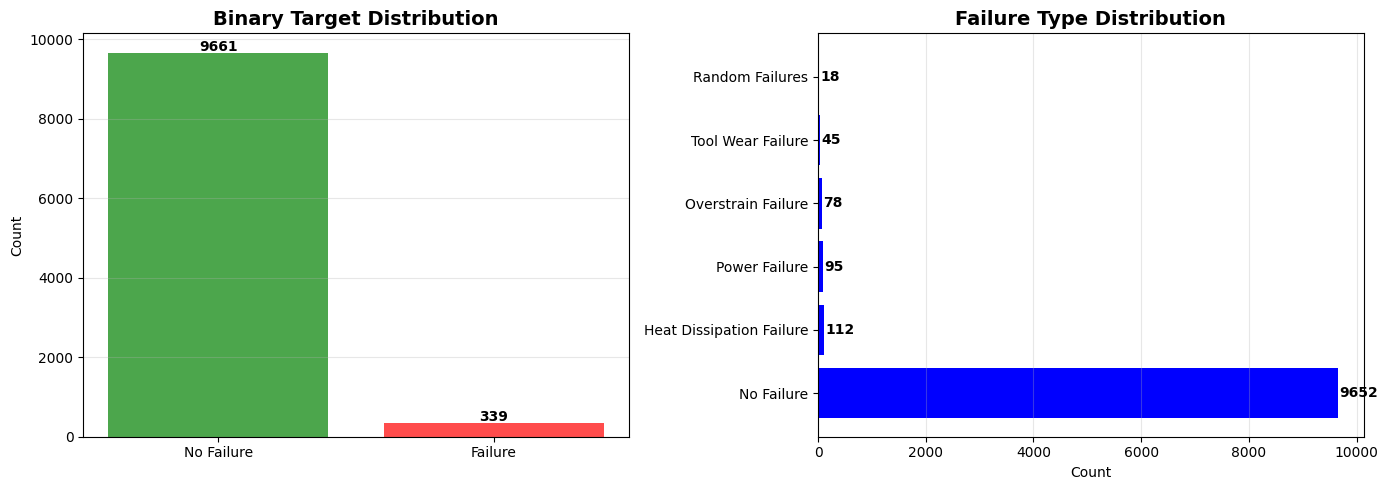

In [58]:
# Target Distribution (Count the Number of '0' - No Failures and '1' - Failures)
print("Target Distribution (Binary Failure):")
target_distribution_df = pred_maint_df['Target'].value_counts()
failure_type_distribution = pred_maint_df['Failure Type'].value_counts()
failure_rate = pred_maint_df['Target'].mean() * 100

# Create a Plot
figure, axes = plt.subplots(1, 2, figsize = (14, 5))

# Binary Target Distribution Plot
axes[0].bar(['No Failure', 'Failure'], target_distribution_df.values, color = ['green', 'red'], alpha = 0.7)
axes[0].set_title('Binary Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, j in enumerate(target_distribution_df.values):
    axes[0].text(i, j + 50, str(j), ha='center', fontweight='bold')

# Failure Types Distribuion Plot
axes[1].barh(failure_type_distribution.index, failure_type_distribution.values, color='blue')
axes[1].set_title('Failure Type Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].grid(axis='x', alpha=0.3)
for i, j in enumerate(failure_type_distribution.values):
    axes[1].text(j + 20, i, str(j), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

#### **3) Feature Analysis: Check for Normal Distribution**

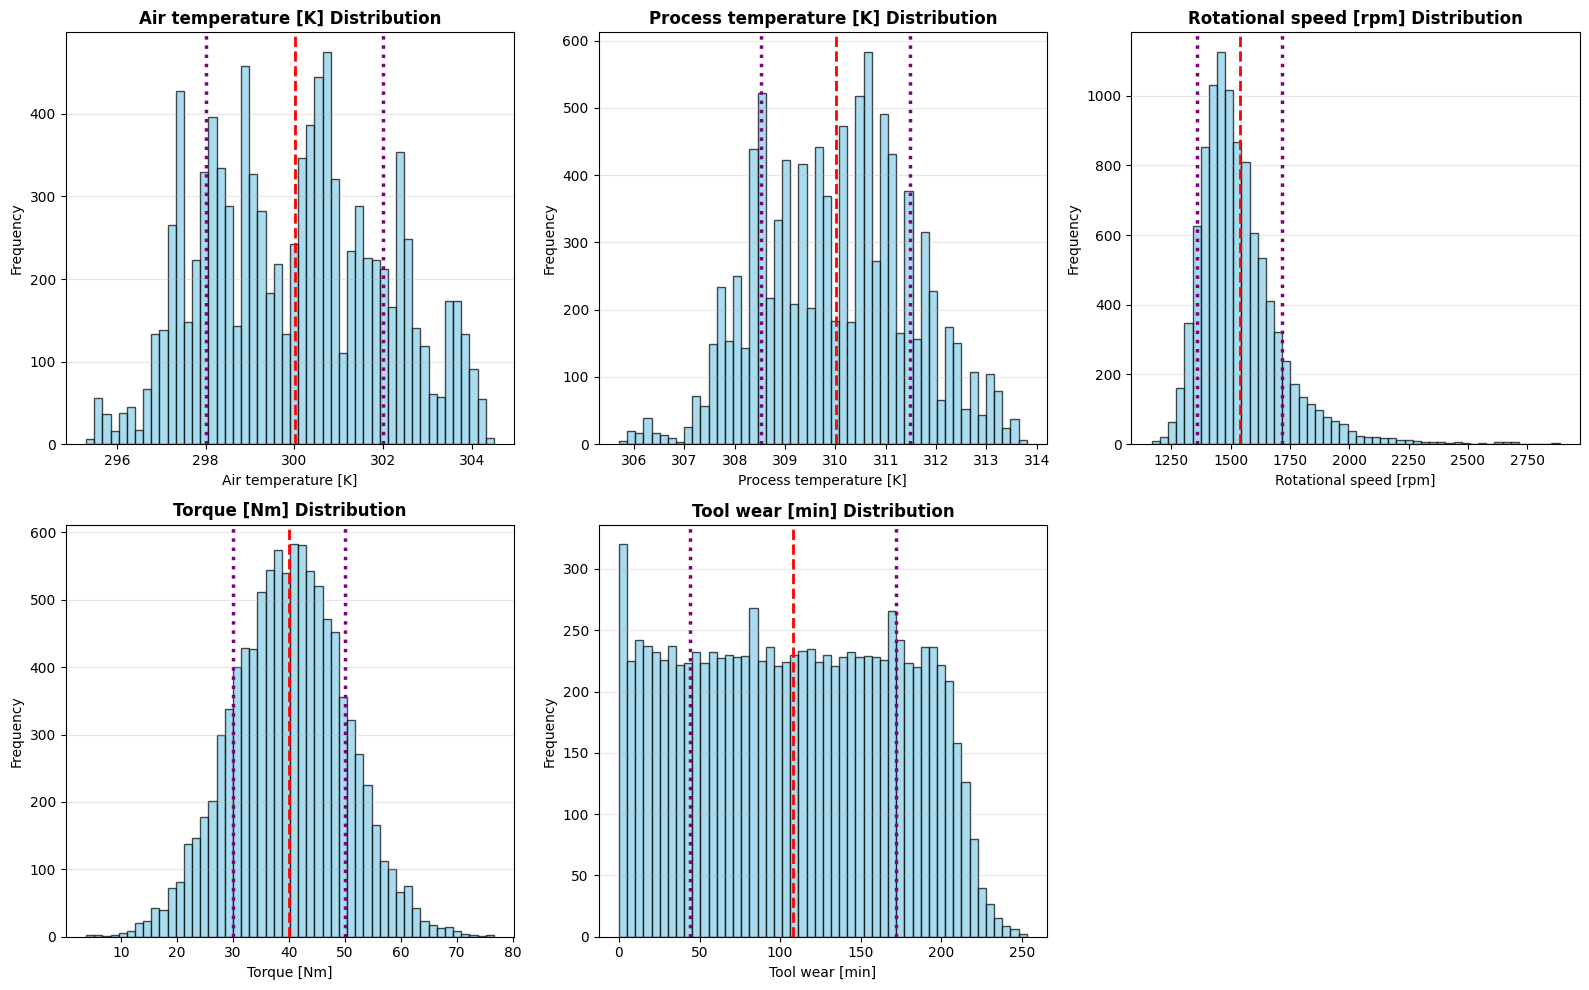

In [59]:
# Select Continuous Features
continuous_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plot Distributions
figure, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    # Histogram with Kernel Density Estimation (Makes Choppy Histogram creates a Smooth Curve)
    axes[i].hist(pred_maint_df[feature], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Mean and Standard Deviation Lines
    mean_val = pred_maint_df[feature].mean()
    std_val = pred_maint_df[feature].std()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(mean_val + std_val, color='purple', linestyle=':', linewidth=2.5, label=f'±1 STD')
    axes[i].axvline(mean_val - std_val, color='purple', linestyle=':', linewidth=2.5)

figure.delaxes(axes[5]) # Remove extra subplot
plt.tight_layout()
plt.show()


| Feature | Distribution Quality | Mean | Spread | Shape Description | Insight | GNB Suitability |
|---------|---------------------|------|--------|-------------------|---------|-----------------|
| **Air Temperature [K]** | Good | ~300K (27°C) | ±2K (Tight) | Nearly perfect bell curve (normal distribution) | Very stable operating temperature, minimal variation |  Perfect with Gaussian assumptions |
| **Process Temperature [K]** | Good | ~310K (37°C) | ±2K (Tight) | Good normal distribution | Process runs ~10K hotter than ambient, well-controlled | Perfect bell curve = ideal for Gaussian NB |
| **Rotational Speed [rpm]** | Decent | ~1500 rpm | ±200 rpm (Moderate) | Mostly normal, slightly left-skewed | Most operations cluster around 1500 rpm, some slower speeds | Still works well, close enough to normal distribution |
| **Torque [Nm]** | Excellent | ~40 Nm | ±10 Nm (Good) | Classic bell curve (textbook normal distribution) | Well-balanced torque distribution, centered operation | Best distribution in the dataset! |
| **Tool Wear [min]** | Problematic | ~108 min | Very wide | Not normal due to flat distribution | Tool wear evenly distributed 0-250 min (machines at all wear stages) | Violates Gaussian assumption but GNB often works anyway |

#### **4) Feature Correlation Analysis**

Naive Bayes assumes feature independence and a High Correlation between Features may affect performance based on the **Pearson Correlation Coefficient Formula** as shown below:

$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \times \sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

Where:
- $r$ = correlation coefficient (-1 to +1)
- $x_i, y_i$ = individual data points for variables X and Y
- $\bar{x}, \bar{y}$ = mean values of X and Y
- $\sum$ = sum of all values
- $n$ = number of data points

<br>

| Correlation Value | Interpretation | Impact on Naive Bayes |
|-------------------|----------------|----------------------|
| 0.0 to ±0.3 | Weak/No correlation | Independent - Great for NB |
| ±0.3 to ±0.7 | Moderate correlation | Somewhat dependent - NB still works |
| ±0.7 to ±1.0 | Strong correlation | Highly dependent - Violates NB assumption |

Correlation Matrix:


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


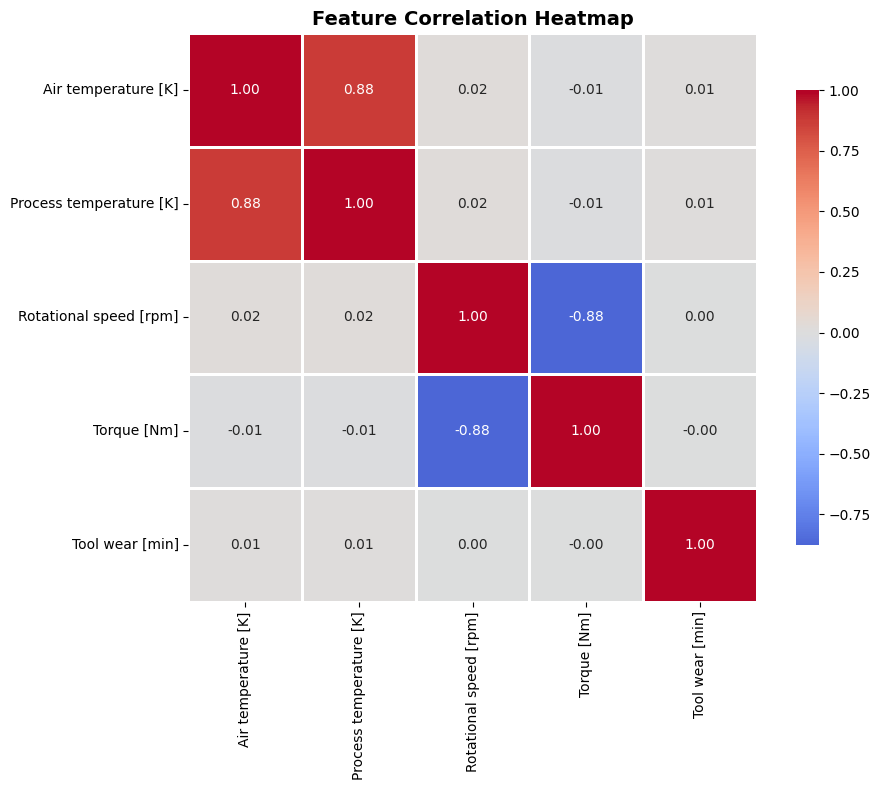

In [60]:
# Correlation matrix
correlation_matrix = pred_maint_df[continuous_features].corr()
print("Correlation Matrix:")
display(correlation_matrix)

# Visualize correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### **5) Feature Comparison: Failure vs No Failure**

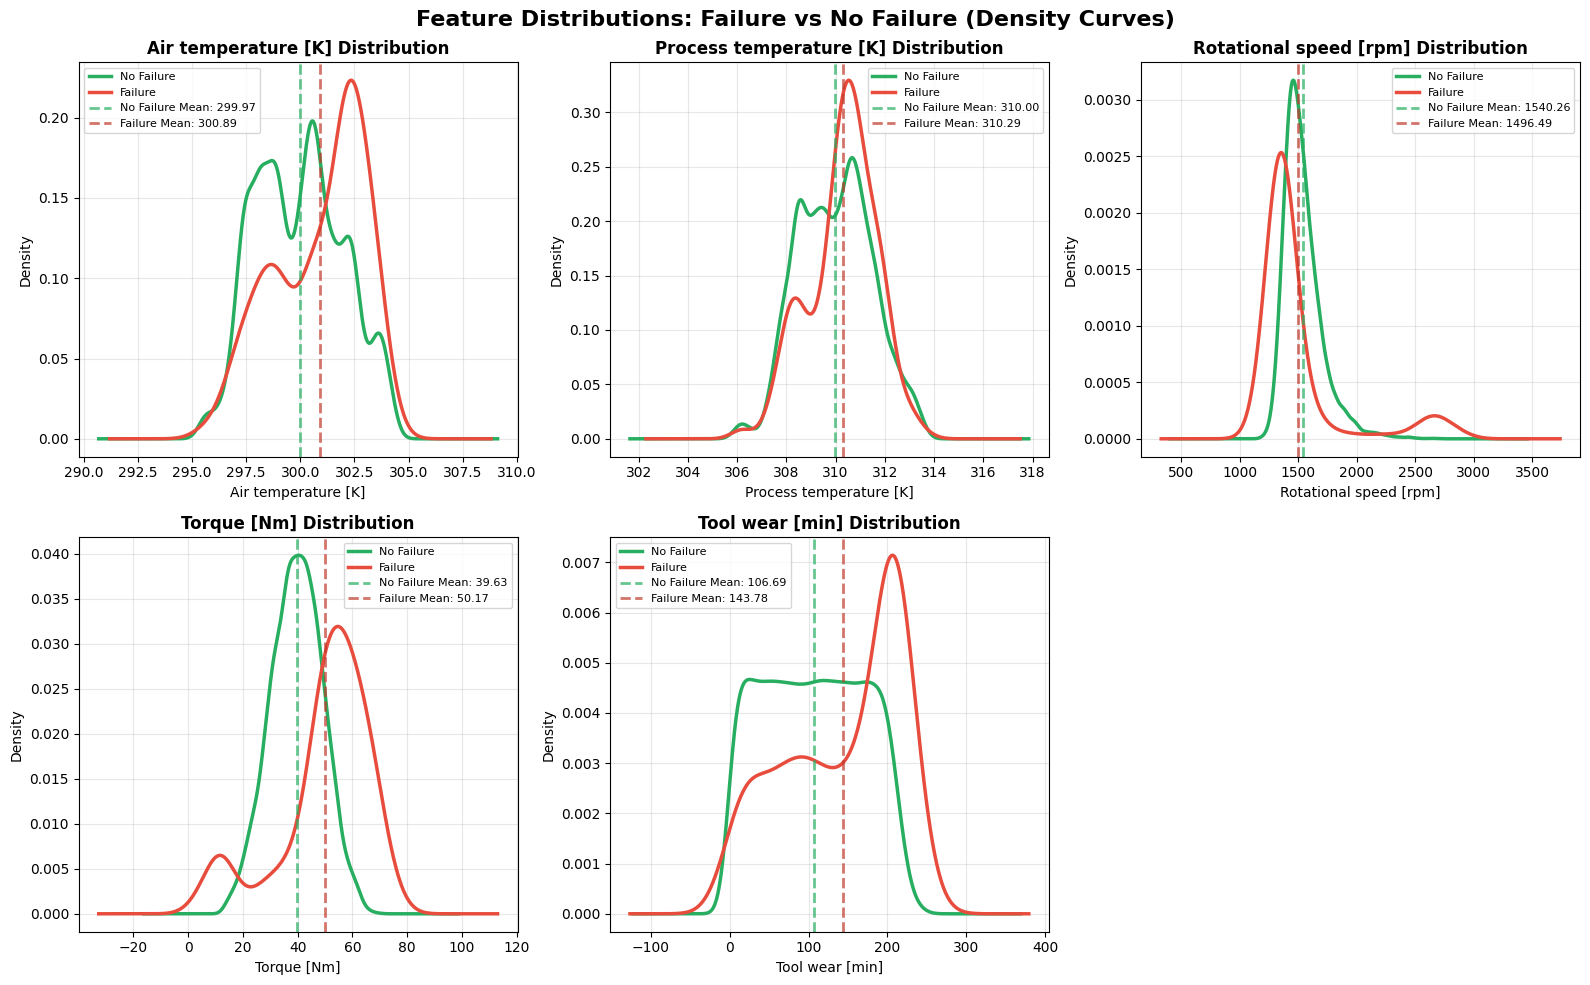

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, feature in enumerate(continuous_features):
    
    # Separate data
    no_failure = pred_maint_df[pred_maint_df['Target'] == 0][feature]
    failure = pred_maint_df[pred_maint_df['Target'] == 1][feature]
    
    # Plot KDE curves
    no_failure.plot(kind='density', ax=axes[i], label='No Failure', color='#27ae60', linewidth=2.5)
    failure.plot(kind='density', ax=axes[i], label='Failure', color='#e74c3c', linewidth=2.5)
    
    # Add mean lines
    axes[i].axvline(no_failure.mean(), color='#27ae60', linestyle='--', linewidth=2, alpha=0.7, label=f'No Failure Mean: {no_failure.mean():.2f}')
    axes[i].axvline(failure.mean(), color='#c0392b', linestyle='--', linewidth=2, alpha=0.7, label=f'Failure Mean: {failure.mean():.2f}')
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

fig.delaxes(axes[5])
plt.suptitle('Feature Distributions: Failure vs No Failure (Density Curves)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


#### **6) Prepare Training and Test Data**

In [62]:
# Select features and target
x_data = pred_maint_df[continuous_features]
y_binary = pred_maint_df['Target']               # Binary classification
y_multiclass = pred_maint_df['Failure Type']     # Multi-class classification

# Split data (80/20)
x_train, x_test, y_train_bin, y_test_bin = sklearn.model_selection.train_test_split(x_data, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

x_train_multi, x_test_multi, y_train_multi, y_test_multi = sklearn.model_selection.train_test_split(x_data, y_multiclass,test_size=0.2,random_state=42,stratify=y_multiclass)

print(f"\nTraining Set size: {len(x_train)} samples (80%)")
print(f"Test Set size: {len(x_test)} samples (20%)")


Training Set size: 8000 samples (80%)
Test Set size: 2000 samples (20%)


#### **7) Train Gaussian Naive Bayes (Binary and Multi-Class)**

In [63]:
# Initialize and Train the Model (Binary)
gauss_NB_Binary = sklearn.naive_bayes.GaussianNB()
gauss_NB_Binary.fit(x_train, y_train_bin)

# Initialize and Train the Model (Multi-Class)
gauss_NB_MultiClass = sklearn.naive_bayes.GaussianNB()
gauss_NB_MultiClass.fit(x_train_multi, y_train_multi)

print("\nModels trained successfully!")

# Make predictions (Binary)
y_pred_bin = gauss_NB_Binary.predict(x_test)
y_pred_proba_bin = gauss_NB_Binary.predict_proba(x_test)
print(f'\nPrediction for Gaussian Naive Bayes (Binary) Model for First 5 Test Dataset:')
for i in range(0,5):
    prediction_label = 'No Failure' if y_pred_bin[i] == 0 else 'Failure'
    prediction_probability = y_pred_proba_bin[i][0] if y_pred_bin[i] == 0 else y_pred_proba_bin[i][1]
    print(f'Predication: {prediction_label} (Confidence: {prediction_probability*100:.2f}%)')

# Make predictions (Multi-Class)
y_pred_MultiClass = gauss_NB_MultiClass.predict(x_test_multi)
y_pred_proba_MultiClass = gauss_NB_MultiClass.predict_proba(x_test_multi)
print(f'\nPrediction for Gaussian Naive Bayes (Multi-Class) Model for First 5 Test Dataset:')
for i in range(0,5):
    prediction_label = 'No Failure' if y_pred_MultiClass[i] == 0 else 'Failure'
    prediction_probability = y_pred_proba_MultiClass[i][0] if y_pred_MultiClass[i] == 0 else y_pred_proba_MultiClass[i][1]
    print(f'Predication: {prediction_label} (Confidence: {prediction_probability*100:.2f}%)')



Models trained successfully!

Prediction for Gaussian Naive Bayes (Binary) Model for First 5 Test Dataset:
Predication: No Failure (Confidence: 80.36%)
Predication: No Failure (Confidence: 98.07%)
Predication: No Failure (Confidence: 97.22%)
Predication: No Failure (Confidence: 99.95%)
Predication: No Failure (Confidence: 90.92%)

Prediction for Gaussian Naive Bayes (Multi-Class) Model for First 5 Test Dataset:
Predication: Failure (Confidence: 99.78%)
Predication: Failure (Confidence: 93.12%)
Predication: Failure (Confidence: 99.89%)
Predication: Failure (Confidence: 99.35%)
Predication: Failure (Confidence: 81.43%)


#### **8) Evaluate the Binary Model**

A **Confusion Matrix** is a Detailed Breakdown showing exactly where the model made correct and wrong predictions. It shows every single prediction versus the actual results.

A **Receiver Operating Characteristic (ROC)** is a graph that shows how well your binary classification model performs across all possible decision thresholds.

A **Classification Report** is a summary scorecard showing how well your model performed on each class.

| Metric | Description |
|--------|-------------|
| **Precision** | Of all predictions made for this class, this indicates how many were correct |
| **Recall** | Of all actual instances of this class, this indicates how many classes were correctly identified |
| **F1-Score** | Balanced measure between precision and recall (harmonic mean) |
| **Support** | Number of actual instances of each class in the test set |
| **Accuracy** | Overall correctness across all classes |
| **Macro Avg** | Simple average across all classes (treats each class equally) |
| **Weighted Avg** | Average weighted by class frequency (accounts for class imbalance) |




Gaussian NB Binary Model Accuracy: 96.00%

Classification Report: Gaussian Naive Bayes (Binary) Model


,precision,recall,f1-score,support
No Failure,0.969574,0.989648,0.979508,1932.00
Failure,0.285714,0.117647,0.166667,68.00
accuracy,0.960000,0.960000,0.960000,0.96
macro avg,0.627644,0.553648,0.573087,2000.00
weighted avg,0.946323,0.960000,0.951872,2000.00


Confusion Matrix: Gaussian Naive Bayes (Binary) Model


,Predicted No Failure,Predicted Failure
Actual No Failure,1912,20
Actual Failure,60,8



ROC Area Under Curve (AUC) Score: 0.9059
The model will correctly rank a failing machine higher than a working machine 90.59% of the time


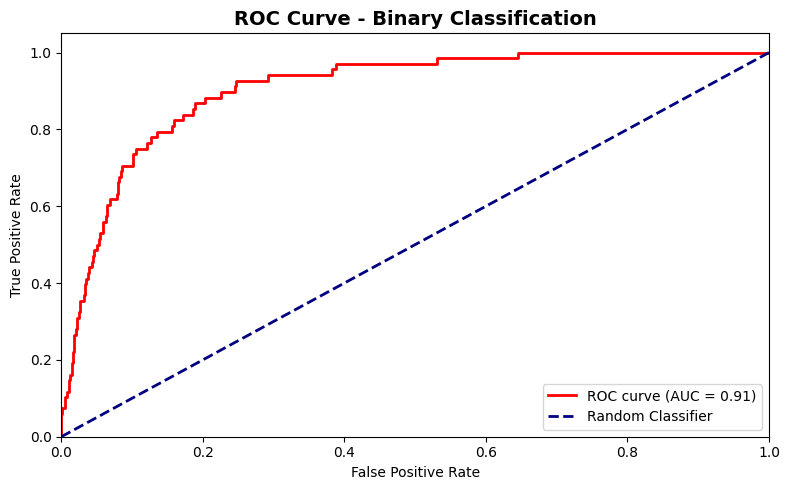

In [64]:
# Accuracy of the Models
gauss_NB_Binary_accuracy = sklearn.metrics.accuracy_score(y_test_bin, y_pred_bin)
print(f'\nGaussian NB Binary Model Accuracy: {gauss_NB_Binary_accuracy*100:.2f}%')

# Classification Report of the Model (Binary)
gauss_NB_Binary_report = sklearn.metrics.classification_report(y_test_bin, y_pred_bin, target_names=['No Failure','Failure'], output_dict=True)
gauss_NB_Binary_report_df = pd.DataFrame(gauss_NB_Binary_report).transpose()
print(f'\nClassification Report: Gaussian Naive Bayes (Binary) Model')
display(gauss_NB_Binary_report_df)

# Confusion Matrix (Binary)
gauss_NB_Binary_cm = sklearn.metrics.confusion_matrix(y_test_bin, y_pred_bin)
gauss_NB_Binary_cm_df = pd.DataFrame(gauss_NB_Binary_cm, index=['Actual No Failure', 'Actual Failure'], columns=['Predicted No Failure','Predicted Failure'])
print("Confusion Matrix: Gaussian Naive Bayes (Binary) Model")
display(gauss_NB_Binary_cm_df)

# Receiver Operating Characteristic (ROC) Curve
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_test_bin, y_pred_proba_bin[:, 1])
# ROC Area Under the Curve (auc)
roc_area_under_curve = sklearn.metrics.roc_auc_score(y_test_bin, y_pred_proba_bin[:, 1]) 
print(f"\nROC Area Under Curve (AUC) Score: {roc_area_under_curve:.4f}") 
print(f"The model will correctly rank a failing machine higher than a working machine {roc_area_under_curve*100:.2f}% of the time")
# AUC = Probability that the model ranks a random positive example higher than a random negative example
# AUC = 0.85 means: 85% of the time, the model will correctly rank a failing machine as higher risk than a working machine"

plt.figure(figsize=(8, 5))
plt.plot(false_positive_rate, true_positive_rate, color='red', lw=2, label=f'ROC curve (AUC = {roc_area_under_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

#### **9) Evaluate the Multi-Class Model**


Gaussian NB Multi-Class Model Accuracy:  94.85%

Classification Report: Gaussian Naive Bayes (Multi-Class) Model


,precision,recall,f1-score,support
Heat Dissipation Failure,0.394737,0.681818,0.500000,22.0000
No Failure,0.981083,0.967358,0.974172,1930.0000
Overstrain Failure,0.523810,0.687500,0.594595,16.0000
Power Failure,0.105263,0.210526,0.140351,19.0000
Random Failures,0.000000,0.000000,0.000000,4.0000
Tool Wear Failure,0.000000,0.000000,0.000000,9.0000
accuracy,0.948500,0.948500,0.948500,0.9485
macro avg,0.334149,0.424534,0.368186,2000.0000
weighted avg,0.956277,0.948500,0.951666,2000.0000


Confusion Matrix: Gaussian Naive Bayes (Binary) Model


,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure,Total Actual
Heat Dissipation Failure,15,7,0,0,0,0,22
No Failure,20,1867,9,34,0,0,1930
Overstrain Failure,0,5,11,0,0,0,16
Power Failure,3,12,0,4,0,0,19
Random Failures,0,4,0,0,0,0,4
Tool Wear Failure,0,8,1,0,0,0,9


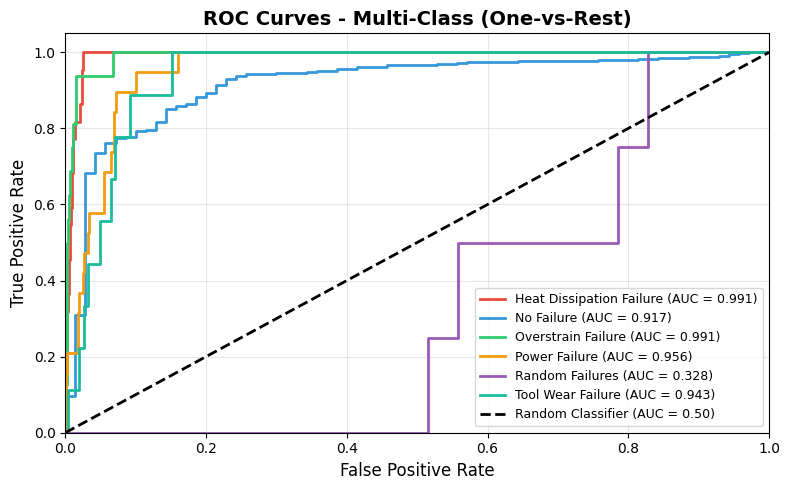

In [65]:
# Accuracy of the Models
gauss_NB_MultiClass_accuracy = sklearn.metrics.accuracy_score(y_test_multi, y_pred_MultiClass)
print(f'\nGaussian NB Multi-Class Model Accuracy:  {gauss_NB_MultiClass_accuracy*100:.2f}%')

# Classification Report of the Model (Multi-Class)
gauss_NB_MultiClass_report = sklearn.metrics.classification_report(y_test_multi, y_pred_MultiClass, output_dict=True, zero_division=0)
gauss_NB_MultiClass_report_df = pd.DataFrame(gauss_NB_MultiClass_report).transpose()
print(f'\nClassification Report: Gaussian Naive Bayes (Multi-Class) Model')
display(gauss_NB_MultiClass_report_df)

# Confusion Matrix (Binary)
gauss_NB_MultiClass_cm = sklearn.metrics.confusion_matrix(y_test_multi, y_pred_MultiClass)
gauss_NB_MultiClass_cm_df = pd.DataFrame(gauss_NB_MultiClass_cm, index=gauss_NB_MultiClass.classes_, columns=gauss_NB_MultiClass.classes_)
# Add Total column (sum of each row = total actual instances)
gauss_NB_MultiClass_cm_df['Total Actual'] = gauss_NB_MultiClass_cm_df.sum(axis=1)
print("Confusion Matrix: Gaussian Naive Bayes (Binary) Model")
display(gauss_NB_MultiClass_cm_df)

# Get class labels for Plotting
classes = gauss_NB_MultiClass.classes_
n_classes = len(classes)
# Binarize the output (one-hot encoding)
y_test_binarized = sklearn.preprocessing.label_binarize(y_test_multi, classes=classes)
# Get prediction probabilities
y_pred_proba_multi = gauss_NB_MultiClass.predict_proba(x_test_multi)

# Compute ROC curve and AUC for each class
fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()

for i, class_name in enumerate(classes):
    fpr_dict[class_name], tpr_dict[class_name], _ = sklearn.metrics.roc_curve(
        y_test_binarized[:, i], 
        y_pred_proba_multi[:, i]
    )
    roc_auc_dict[class_name] = sklearn.metrics.auc(fpr_dict[class_name], tpr_dict[class_name])

# Plot all ROC curves
plt.figure(figsize=(8, 5))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for i, (class_name, color) in enumerate(zip(classes, colors)):
    plt.plot(fpr_dict[class_name], tpr_dict[class_name], 
             color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc_dict[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class (One-vs-Rest)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### **10) Feature Importance Via Class Means**


Mean Values for Each Class for 'Failure' and 'No Failure':


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
No Failure,299.973295,309.994747,1540.711217,39.646850,106.503299
Failure,300.922509,310.328782,1500.730627,50.171218,141.387454
Absolute Difference,0.949214,0.334035,39.980590,10.524368,34.884155


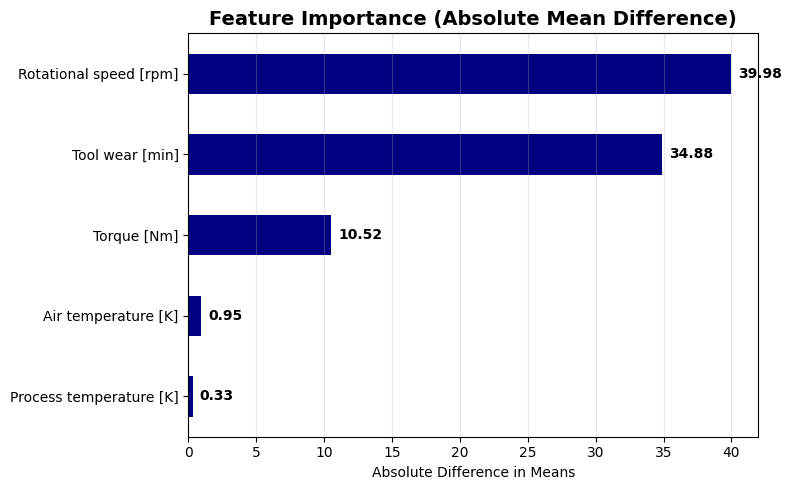

In [66]:
# Get class means from the model
class_means = pd.DataFrame(gauss_NB_Binary.theta_,columns=continuous_features,index=['No Failure', 'Failure'])

# Calculate differences
mean_diff = class_means.loc['Failure'] - class_means.loc['No Failure']
mean_diff_abs = mean_diff.abs()
class_means.loc['Absolute Difference'] = mean_diff_abs
print(f"\nMean Values for Each Class for 'Failure' and 'No Failure':")
display(class_means)

# Visualize on a Plot
ax = mean_diff.abs().sort_values().plot(kind='barh', figsize=(8, 5), color='navy')
plt.title('Feature Importance (Absolute Mean Difference)', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Difference in Means')
plt.grid(axis='x', alpha=0.3)

# Add values on each bar
for i, v in enumerate(mean_diff.abs().sort_values()):
    ax.text(v + 0.5, i, f'{v:.2f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

#### **11) Predict with Custom Test Data**

In [67]:
def predict_machine_status(air_temp, process_temp, rot_speed, torque, tool_wear):
    """
    Predict machine failure probability given sensor readings
    
    Params:
    air_temp(float): Air temperature in Kelvin
    process_temp (float): Process temperature in Kelvin
    rot_speed(int): Rotational speed in rpm
    torque(float): Torque in Nm
    tool_wear(int): Tool wear in minutes
    
    Returns:
    Prediction and probabilities
    """
    # Create input as DataFrame with proper column names (fixes warning)
    input_data = pd.DataFrame([[air_temp, process_temp, rot_speed, torque, tool_wear]], 
                              columns=continuous_features)
    
    # Make prediction for Failure or No Failure
    prediction = gauss_NB_Binary.predict(input_data)[0]
    probabilities = gauss_NB_Binary.predict_proba(input_data)[0]
    
    # Make prediction for Failure Type
    failure_type_pred = gauss_NB_MultiClass.predict(input_data)[0]
    failure_type_proba = gauss_NB_MultiClass.predict_proba(input_data)[0]
    
    prediction_label = 'No Failure' if prediction == 0 else 'Failure'
    prediction_probability = probabilities[prediction] * 100
    
    print(f"Prediction: {prediction_label}")
    print(f"Confidence: {prediction_probability:.2f}%")
    
    if prediction == 1:
        # Exclude "No Failure" and find most likely actual failure type
        failure_classes_only = []
        failure_probas_only = []
        
        for i, failure_class in enumerate(gauss_NB_MultiClass.classes_):
            if failure_class != 'No Failure':
                failure_classes_only.append(failure_class)
                failure_probas_only.append(failure_type_proba[i])
        
        # Find the most likely actual failure type
        max_prob_idx = np.argmax(failure_probas_only)
        most_likely_failure = failure_classes_only[max_prob_idx]
        confidence = failure_probas_only[max_prob_idx] * 100
        
        print(f"Most Likely Failure Type: {most_likely_failure} ({confidence:.2f}%)")
    
    return prediction, probabilities


print("\nTest Case 1: Normal Operation")
predict_machine_status(air_temp=300.0, process_temp=310.0, rot_speed=1500, torque=40.0, tool_wear=100)

print("\nTest Case 2: High Stress Conditions (High RPM and Torque)")
predict_machine_status(air_temp=303.0, process_temp=313.0, rot_speed=2500, torque=60.0, tool_wear=100)

print("\nTest Case 3: Extreme Tool Wear (Low Speed, High Torque and High Toor Wear)")
predict_machine_status(air_temp=300.0, process_temp=310.0, rot_speed=1300, torque=70.0, tool_wear=180)


Test Case 1: Normal Operation
Prediction: No Failure
Confidence: 99.50%

Test Case 2: High Stress Conditions (High RPM and Torque)
Prediction: Failure
Confidence: 100.00%
Most Likely Failure Type: Power Failure (100.00%)

Test Case 3: Extreme Tool Wear (Low Speed, High Torque and High Toor Wear)
Prediction: Failure
Confidence: 69.30%
Most Likely Failure Type: Overstrain Failure (26.32%)


(np.int64(1), array([0.30697022, 0.69302978]))